In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/shuva/Downloads/full_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [3]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [4]:
# меняем текстовые колонки на числовые
object_columns = df.select_dtypes(include='object').columns.tolist()
for i in object_columns:
    u = np.unique(df[i])
    t = 0
    for j in u:
        df.loc[(df[i] == j), i] = t
        t += 1
    df[i] = pd.to_numeric(df[i])

In [5]:
# явный дисбаланс в таргет переменной
df['stroke'].value_counts()

0    4733
1     248
Name: stroke, dtype: int64

In [6]:
# попробуем построить модель на дисбалансе
# тестовая и тренировочная выборка
X = df.drop(columns='stroke')
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X_test2, y_test2 = X_test, y_test

Confusion matrix 
 [[947   0]
 [ 50   0]]
Recall: 0.000
Precision: 0.000
Accuracy: 0.950
AUC: 0.842


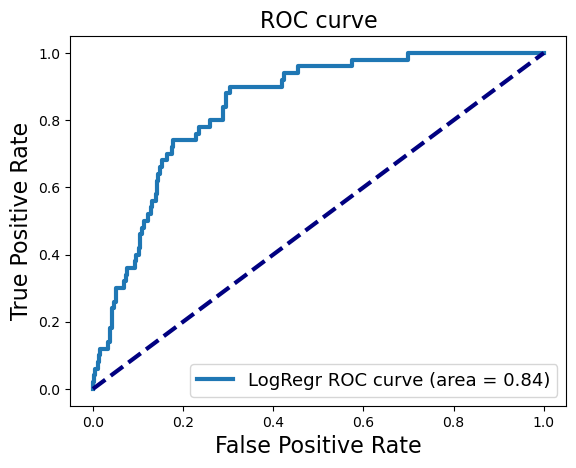

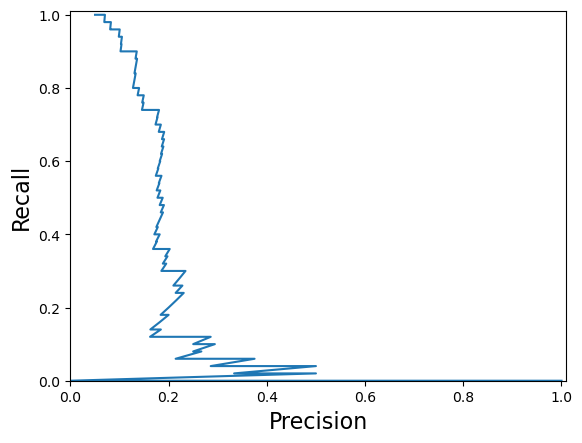

In [8]:
# Логит модель
logreg1 = LogisticRegression(C=10, max_iter=1000, ).fit(X_train, y_train)
logreg1_pred = logreg1.predict(X_test)
print('Confusion matrix \n', confusion_matrix(y_test, logreg1_pred))
print('Recall: {:.3f}'.format(recall_score(y_test, logreg1_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, logreg1_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, logreg1_pred)))

logreg1_pred_roc = logreg1.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, logreg1_pred_roc.reshape(-1, 1))
print('AUC: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, logreg1_pred_roc.reshape(-1, 1))
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.show()

In [9]:
# Пробуем случайный лес
rf1 = RandomForestClassifier(random_state=0).fit(X_train, y_train)
rf1_pred = rf1.predict(X_test)
print('Confusion matrix \n', confusion_matrix(y_test, rf1_pred))
print('Recall: {:.3f}'.format(recall_score(y_test, rf1_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, rf1_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, rf1_pred)))

Confusion matrix 
 [[945   2]
 [ 50   0]]
Recall: 0.000
Precision: 0.000
Accuracy: 0.948


Модель хорошо предсказывает нули, но плохо положительные случаи

In [10]:
# Пробуем AdaBoostClassifier
adab1 = AdaBoostClassifier(random_state=0).fit(X_train, y_train)
adab1_pred = adab1.predict(X_test)
print('Confusion matrix \n', confusion_matrix(y_test, adab1_pred))
print('Recall: {:.2f}'.format(recall_score(y_test, adab1_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, adab1_pred)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, adab1_pred)))

Confusion matrix 
 [[944   3]
 [ 49   1]]
Recall: 0.02
Precision: 0.25
Accuracy: 0.95


In [11]:
# Пробуем GradientBoostingClassifier
gb1 = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
gb1_pred = gb1.predict(X_test)
print('Confusion matrix \n', confusion_matrix(y_test, gb1_pred))
print('Recall: {:.2f}'.format(recall_score(y_test, gb1_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, gb1_pred)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, gb1_pred)))

Confusion matrix 
 [[945   2]
 [ 48   2]]
Recall: 0.04
Precision: 0.50
Accuracy: 0.95


Confusion matrix 
 [[938   9]
 [ 48   2]]
Recall: 0.04
Precision: 0.18
Accuracy: 0.94
AUC: 0.810


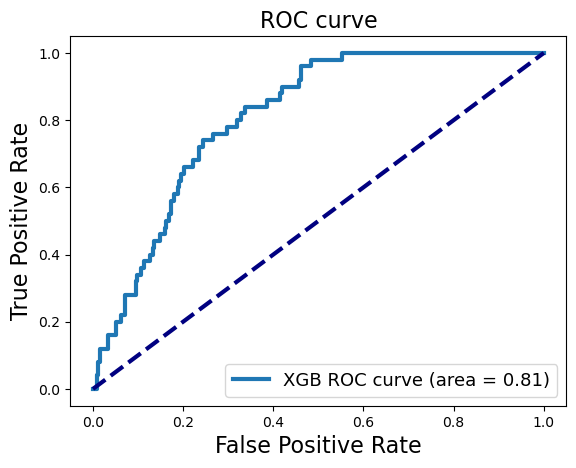

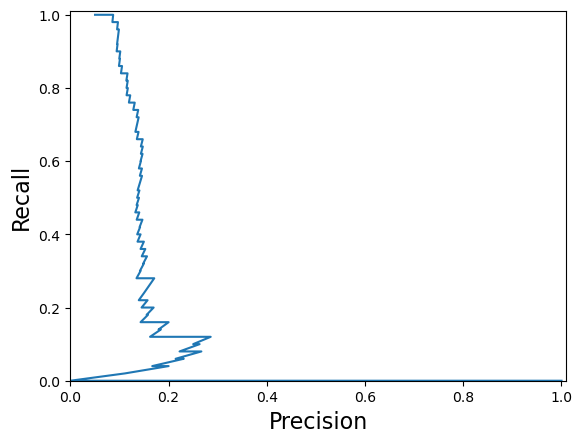

In [12]:
# Пробуем XGBClassifier
xgb1 = XGBClassifier(random_state=0).fit(X_train, y_train)
xgb1_pred = xgb1.predict(X_test)
print('Confusion matrix \n', confusion_matrix(y_test, xgb1_pred))
print('Recall: {:.2f}'.format(recall_score(y_test, xgb1_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, xgb1_pred)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, xgb1_pred)))

xgb1_pred_roc = xgb1.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, xgb1_pred_roc.reshape(-1, 1))
print('AUC: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='XGB ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, xgb1_pred_roc.reshape(-1, 1))
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.show()

In [13]:
# Применяем SMOTE
X, y = SMOTE(random_state=0).fit_resample(X, y)
Counter(y)

Counter({1: 4733, 0: 4733})

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Confusion matrix 
 [[728 216]
 [185 765]]
Recall: 0.805
Precision: 0.780
Accuracy: 0.788
AUC: 0.810


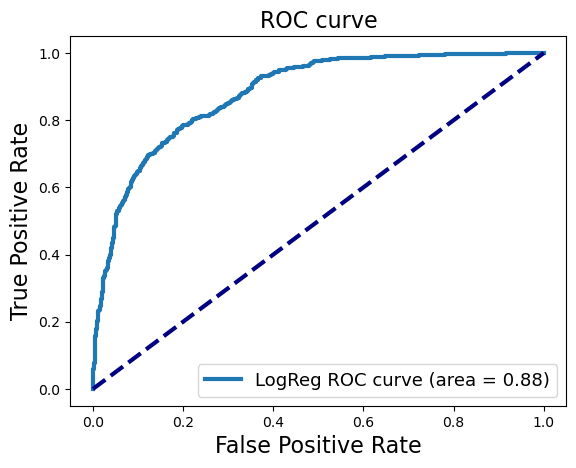

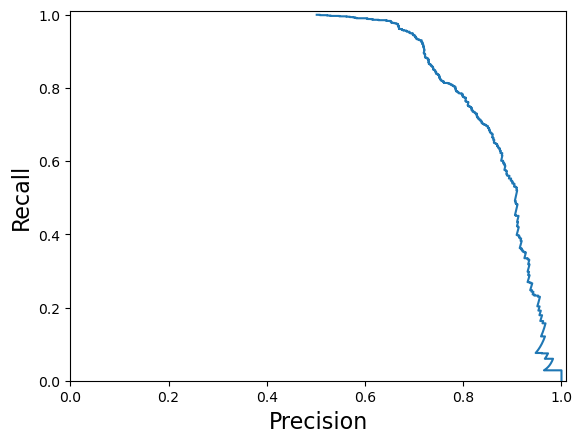

In [15]:
# Логит модель
logreg2 = LogisticRegression(C=0.01, max_iter=2000).fit(X_train, y_train)
logreg2_pred = logreg2.predict(X_test)
print('Confusion matrix \n', confusion_matrix(y_test, logreg2_pred))
print('Recall: {:.3f}'.format(recall_score(y_test, logreg2_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, logreg2_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, logreg2_pred)))
print('AUC: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

logreg_pred_roc = logreg2.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, logreg_pred_roc.reshape(-1, 1))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='LogReg ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, logreg_pred_roc.reshape(-1, 1))
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.show()

In [16]:
for i in range(0, X_train.columns.shape[0]):
    print(X_train.columns[i], round(logreg2.coef_[0][i], 2))
print('Constant: ', round(logreg2.intercept_[0], 2))

gender -0.62
age 0.08
hypertension -0.4
heart_disease -0.41
ever_married -0.52
work_type -0.61
Residence_type -0.68
avg_glucose_level 0.01
bmi 0.01
smoking_status -0.33
Constant:  -3.86


In [17]:
# Пробуем случайный лес
rf2 = RandomForestClassifier(random_state=0).fit(X_train, y_train)
rf2_pred = rf2.predict(X_test)
print('Confusion matrix \n', confusion_matrix(y_test, rf2_pred))
print('Recall: {:.3f}'.format(recall_score(y_test, rf2_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, rf2_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, rf2_pred)))

Confusion matrix 
 [[862  82]
 [ 45 905]]
Recall: 0.953
Precision: 0.917
Accuracy: 0.933


In [18]:
# Пробуем AdaBoostClassifier
adab2 = AdaBoostClassifier(random_state=0).fit(X_train, y_train)
adab2_pred = adab2.predict(X_test)
print('Confusion matrix \n', confusion_matrix(y_test, adab2_pred))
print('Recall: {:.2f}'.format(recall_score(y_test, adab2_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, adab2_pred)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, adab2_pred)))

Confusion matrix 
 [[739 205]
 [164 786]]
Recall: 0.83
Precision: 0.79
Accuracy: 0.81


In [19]:
# Пробуем GradientBoostingClassifier
gb2 = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
gb2_pred = gb2.predict(X_test)
print('Confusion matrix \n', confusion_matrix(y_test, gb2_pred))
print('Recall: {:.2f}'.format(recall_score(y_test, gb2_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, gb2_pred)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, gb2_pred)))

Confusion matrix 
 [[771 173]
 [104 846]]
Recall: 0.89
Precision: 0.83
Accuracy: 0.85


Confusion matrix 
 [[888  56]
 [ 46 904]]
Recall: 0.952
Precision: 0.942
Accuracy: 0.946
AUC: 0.989


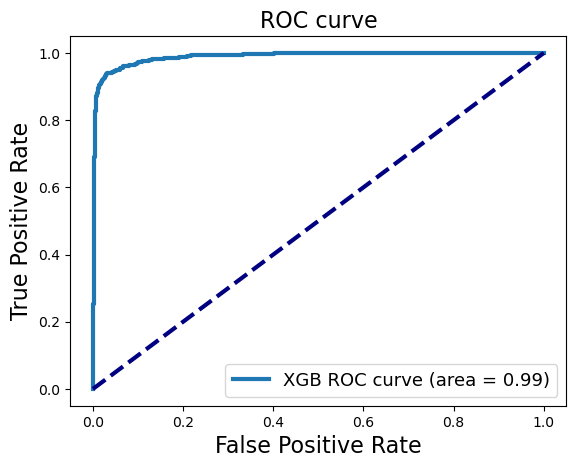

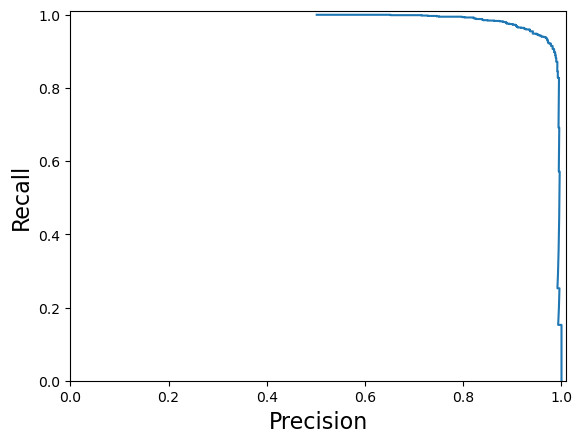

In [20]:
# Пробуем XGBClassifier
xgb2 = XGBClassifier(random_state=0).fit(X_train, y_train)
xgb2_pred = xgb2.predict(X_test)
print('Confusion matrix \n', confusion_matrix(y_test, xgb2_pred))
print('Recall: {:.3f}'.format(recall_score(y_test, xgb2_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, xgb2_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, xgb2_pred)))

xgb2_pred_roc = xgb2.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, xgb2_pred_roc.reshape(-1, 1))
print('AUC: {:.3f}'.format(auc(fpr_lr, tpr_lr)))

plt.plot(fpr_lr, tpr_lr,  lw=3, label='XGB ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, xgb2_pred_roc.reshape(-1, 1))
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.show()

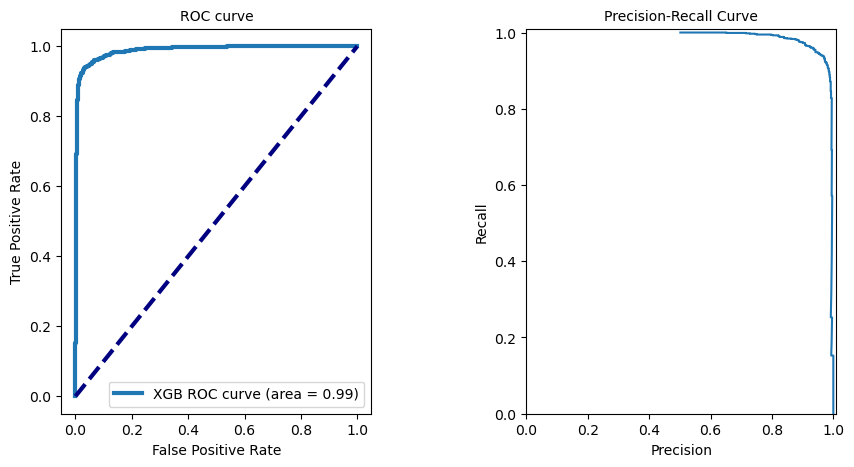

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first ROC curve
axes[0].plot(fpr_lr, tpr_lr, lw=3, label='XGB ROC curve (area = {:0.2f})'.format(auc(fpr_lr, tpr_lr)))
axes[0].set_xlabel('False Positive Rate', fontsize=10)
axes[0].set_ylabel('True Positive Rate', fontsize=10)
axes[0].set_title('ROC curve', fontsize=10)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

# Plot the second Precision-Recall curve
axes[1].plot(precision, recall)
axes[1].set_title('Precision-Recall Curve', fontsize=10)
axes[1].set_xlim([0.0, 1.01])
axes[1].set_ylim([0.0, 1.01])
axes[1].set_xlabel('Precision', fontsize=10)
axes[1].set_ylabel('Recall', fontsize=10)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)

# Show the figure
plt.show()

In [22]:
# Попробуем на обычном тестовом наборе, без SMOTE
# XGB
xgb2_pred2 = xgb2.predict(X_test2)
print(Counter(y_test2), '\n')

print('XGB')
print('Confusion matrix \n', confusion_matrix(y_test2, xgb2_pred2))
print('Recall: {:.3f}'.format(recall_score(y_test2, xgb2_pred2)))
print('Precision: {:.3f}'.format(precision_score(y_test2, xgb2_pred2)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test2, xgb2_pred2)), '\n')

# LogReg
print('LogReg')
logreg2_pred2 = logreg2.predict(X_test2)
print('Confusion matrix \n', confusion_matrix(y_test2, logreg2_pred2))
print('Recall: {:.3f}'.format(recall_score(y_test2, logreg2_pred2)))
print('Precision: {:.3f}'.format(precision_score(y_test2, logreg2_pred2)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test2, logreg2_pred2)))

Counter({0: 947, 1: 50}) 

XGB
Confusion matrix 
 [[931  16]
 [ 16  34]]
Recall: 0.680
Precision: 0.680
Accuracy: 0.968 

LogReg
Confusion matrix 
 [[736 211]
 [ 11  39]]
Recall: 0.780
Precision: 0.156
Accuracy: 0.777


XGBClassifier наилучший с точки зрения concusion matrix